# Map and global navigation

<div style="border:1px solid black; padding:20px 20px;text-align: justify;text-justify: inter-word">
<strong> MAP and global navigation<br/> </strong><br/>
The objective of this notebook is to explain how we define the map of the thymio and find the shortest path around the fixed obstacles.<br/> <br/>
We will import all the necessary functions and code to make everything work, then we will look at small examples to understand how it works but also how to use it.   
</div>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

%matplotlib inline

## I. Map class

The Map class regroup most of components necessary to the map:
- Parameters: start,end,Obstacles,path,checkpoints,visited_nodes
- Run of A_star algorithm (definition of the algorithm is outside)
- plotting the Map

In [2]:
class Map:
    def __init__(self, width, height,start,end,grid):
        self.width = width
        self.height = height
        self.start = start
        self.end = end
        self.grid = grid
        self.path = np.empty(0)
        self.checkpoints = np.empty(0)
        self.visited = np.empty(0)
        self.path_solved = False
        self.fig, self.ax = plt.subplots(figsize=(7,7))
         
    def run_map(self,verbose=False):
        """
        Function to run the A_star algorithm on the Map.
        :param verbose: plot the Map if true
        """
        start = self.start[:2]
        self.path,self.checkpoints,self.visited = run_Astar(self.grid,start,self.end, self.width, self.height)
        self.path_solved = True
        if(verbose):
            self.create_plot()

    def draw_arrow(self):
        """
        Function to draw an arrow giving the angle of robot.
        Only plot it we have the angle information  
        """
        if len(self.start) == 3:
            arrow_length = self.width / self.height
            plt.arrow(self.start[0], self.start[1], arrow_length * math.cos(self.start[2]), arrow_length * math.sin(self.start[2]), head_width=arrow_length/5)

    def create_plot(self):
        """
        Function to create a figure of the desired dimensions & grid
        Then draw all elements of the map (start,end,path,visited_nodes,checkpoints)
        """
        if self.width < self.height:
            max_val = self.height
        else:
            max_val = self.width
        # Grid and axis definition
        major_ticks = np.arange(0, max_val+1, 5)
        minor_ticks = np.arange(0, max_val+1, 1)
        self.ax.set_xticks(major_ticks)
        self.ax.set_xticks(minor_ticks, minor=True)
        self.ax.set_yticks(major_ticks)
        self.ax.set_yticks(minor_ticks, minor=True)
        self.ax.grid(which='minor', alpha=0.2)
        self.ax.grid(which='major', alpha=0.5)
        self.ax.set_ylim([-1,self.height])
        self.ax.set_xlim([-1,self.width])
        self.ax.grid(True)
        # Start and end definition
        self.draw_arrow()
        self.ax.scatter(self.start[0], self.start[1], marker="o", color = 'green', s=200);
        self.ax.scatter(self.end[0], self.end[1], marker="o", color = 'purple', s=200);
        # Plot the best path found and the list of visited nodes
        if (self.path_solved):
            self.ax.scatter(self.visited[0], self.visited[1], marker="o", color = 'orange');
            self.ax.plot(self.path[0], self.path[1], marker="o", color = 'blue');
            self.ax.scatter(self.checkpoints[0],self.checkpoints[1],marker="o",color = 'cyan',s=80);
        # Plot the Obstacles    
        cmap = colors.ListedColormap(['white', 'red']) # Select the colors with which to display obstacles and free cells
        self.ax.imshow(self.grid.transpose(), cmap=cmap)


## II. A*star algorithm

- Calculates shortest path in a 2 dimension grid. Each step the robot can choose to go: up,down,left,right,or any diagonal displacement 
- Can also calculate the checkpoints: it represents all the points in a path that shows a discontinuity. Between two checkpoints the robot can go straight without turning.

In [3]:
def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]


def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

def A_Star(start, goal, h, coords, occupancy_grid,width,height,movement_type="8N"):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE
    # -----------------------------------------
    
    assert start[0]>=0 and start[1]>=0 and start[0]<width and start[1]<height, "start not contained in the map"
    assert goal[0]>=0 and goal[1]>=0 and goal[0]<width and goal[1]<height, "end goal not contained in the map"
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet

def checkpoints_path(path):
    """
    Calculation of the checkpoints 
    """
    steps = np.size(path,1)
    checkpoints =np.reshape(path[:,0],(2,-1))
    for i in range (steps):
        nb_i = np.reshape(path[:,i],(2,-1))
        if(i==(steps-1)):
            checkpoints = np.append(checkpoints,nb_i,axis =1)
        elif (i!=0):
            if(((path[0,(i+1)]-path[0,i]) != (path[0,i]-path[0,(i-1)])) or ((path[1,(i+1)]-path[1,i]) != (path[1,i]-path[1,(i-1)]))):
                checkpoints = np.append(checkpoints,nb_i,axis =1)
    return checkpoints  

def run_Astar(occupancy_grid,start,goal, width, height): 
    """
    Initialisation and run the A*star algorithm 
    """
    # List of all coordinates in the grid
    x,y = np.mgrid[0:width:1, 0:height:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
    coords = list([(int(x[0]), int(x[1])) for x in pos])
    #print(coords)

    # Define the heuristic, here = distance to goal ignoring obstacles
    h = np.linalg.norm(pos - goal, axis=-1)
    h = dict(zip(coords, h))

    # Run the A* algorithm
    path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid, width, height, movement_type="8N")
    path = np.array(path).reshape(-1, 2).transpose()
    visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
    checkpoints = checkpoints_path(path)
    return path,checkpoints,visitedNodes

## III. Examples

### III.i Map example 1

Showing how initialize coorectly a map and plot it.

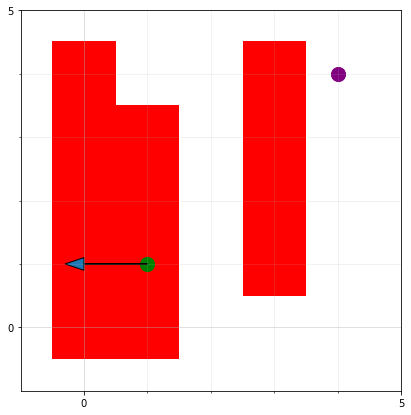

In [4]:
#Create Map instance
width2 = 5
height2 = 5
start2 = (1, 1,math.pi)#green start the third element is the angle in rad
end2 = (4, 4) #red dot define end point
grid2 = np.array([[1,1,1,1,1],[1,1,1,1,0],[0,0,0,0,0],[0,1,1,1,1],[0,0,0,0,0]])

m2 = Map(width2,height2,start2,end2,grid2)
m2.create_plot()

If we run this map it will throw an error by giving: Exception: Start node is not traversable
- Try the line below if you want

In [5]:
#m2.run_map(True)

### III.ii Map example 2

Showing a correct initialisation of the map then running the map and plot it.

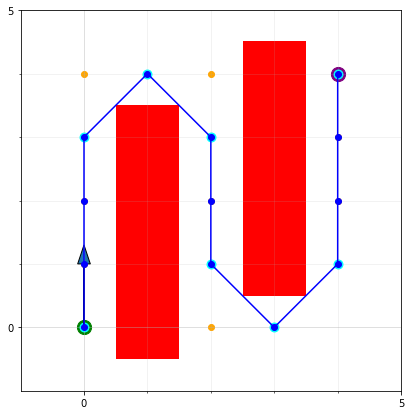

In [6]:
#Create Map instance
width = 5
height = 5
start = (0, 0,math.pi/2)#green start the third element is the angle in rad
end = (4, 4) #red dot define end point
grid = np.array([[0,0,0,0,0],[1,1,1,1,0],[0,0,0,0,0],[0,1,1,1,1],[0,0,0,0,0]])

m = Map(width,height,start,end,grid)

# run map
m.run_map(True)

## IV Map upgrades

To make the map works with a real physical system, and the rest of the project we have added functionalites. 

### IV.i Grow Obstacles

In the Map seen above, the robot is defined with a point. In order to take into account the size of the thymio (11 cm x 11.2 cm x 5.3 cm) we have chosen to enlarge the size of the obstacles in the discretization.
This function is also defined in the Map class.

In [7]:
def box_range(coord,coord_size,Margin):
    coord_low = np.arange((coord-Margin), coord)
    coord_high = np.arange(coord,(coord+Margin+1))
    coord_tot = np.concatenate((coord_low,coord_high),0)
    coord_tot = coord_tot[coord_tot >= 0]
    coord_tot = coord_tot[coord_tot < coord_size]
    return coord_tot

def Obstacles_real(size_thymio,size_pixel,grid,width,height):
    Margin_px = size_thymio/size_pixel
    temp_grid = grid.copy()
    Obs_coords = np.nonzero(grid > 0.5)
    steps = np.size(Obs_coords,1)
    for i in range (steps):
        x_i = Obs_coords[0][i]
        y_i = Obs_coords[1][i]
        range_x = box_range(x_i,width,Margin_px)
        range_y = box_range(y_i,height,Margin_px)
        for j in range_x:
            for k in range_y:
                if (np.linalg.norm((x_i-j,y_i-k)) < Margin_px ):
                    temp_grid[int(j),int(k)] = 1
    return temp_grid

### IV.ii checkpoints with Map example 2

In [8]:
print(m.path)
print(m.checkpoints)

[[0 0 0 0 1 2 2 2 3 4 4 4 4]
 [0 1 2 3 4 3 2 1 0 1 2 3 4]]
[[0 0 1 2 2 3 4 4]
 [0 3 4 3 1 0 1 4]]


For real size of checkpoints (in mm) for example we need to do:

In [9]:
pixel_size = 10 # each pixel is 10mm for example
real_checkpoints = m.checkpoints*pixel_size
print(real_checkpoints)

[[ 0  0 10 20 20 30 40 40]
 [ 0 30 40 30 10  0 10 40]]


### IV.ii global example

Here we will test with a random generated map, with random obstacles.
The first map will not have the obstacles grown, but the second will.

In [10]:
# Size of Map and start,end
width = 100
height = 100
start = (0,0)
end = (99,99)
# random obstacles
np.random.seed(0) # To guarantee the same outcome on all computers
data = np.random.rand(width, height) * 100 # Create a grid of width x height random values
# Converting the random values into occupied and free cells
limit = 95
occupancy_grid = data.copy()
occupancy_grid[data>limit] = 1
occupancy_grid[data<=limit] = 0

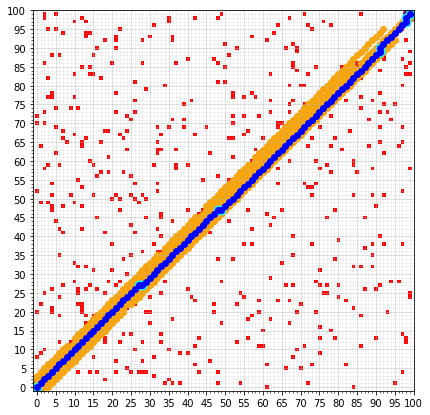

In [11]:
m3 = Map(width,height,start,end,occupancy_grid)
m3.run_map(True)

For the example we choose a robot size just superior to srqt(2): each obstacle will become a small block

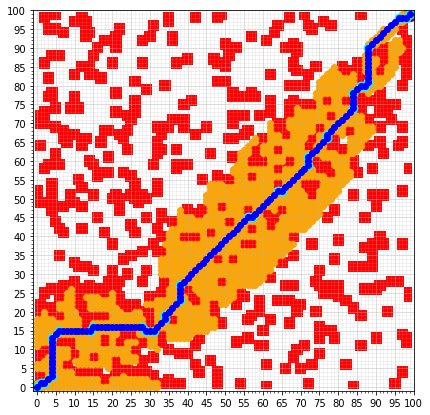

In [12]:
size_thymio = 1.42
size_pixel = 1
grid2 = Obstacles_real(size_thymio,size_pixel,occupancy_grid,width,height)
m4 = Map(width,height,start,end,grid2)
m4.run_map(True)

## V. Limitations

For this project we used the A* algorithm due to it's completness and optimality. One major drawback is that it's quite computationally heavy and for very large maps it tends to be slow.

In [14]:
import time 
start_timer1 = time.time()
##### Put testing functions here ####
#########################################################
end_timer1 = time.time()
print(f"Runtime of the program is {end_timer1 - start_timer1}")

Runtime of the program is 0.00099945068359375


Here's a recap of some of the timer tests:

| dimensions  | Map without growth obstacles[s] | Map with growth Obstacles[s] |
|:---------------------------:|:---------------------:|:-------------------------------:|
|            50x50            |           2.25        |           1.87          |
|           100x100           |         43.3         |           59.48           |

Additional data for the 4 test:<br/>
Not calculating checkpoints for 100x100: 55.6 seconds <br/>
Not plotting a 100x100 : 58.05 seconds <br/>
Obstacles growth takes 0.17 seconds for 100x100: the difference in due mainly in increase in difficulty of solving the map <br/>

Complexity increase dramatically with the size of the map, the cost of the main function in order are for a 100x100:
1. A star algorithm (54s)
2. Calculating checkpoints(3.88s)
3. Plotting(1.43s) 
4. Growing the obstacles(0.17s)